In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import logging
logging.basicConfig(level=logging.INFO, format='')
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import rdkit
from sklearn.impute import SimpleImputer
from scipy.stats import kurtosis, skew
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Descriptors import MoleculeDescriptors
import sys
sys.path.append('C:\\Users\\PY\\jtvae2')
sys.path.append('../')
import requests
import torch
import pubchempy as pcp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
from fast_molvae.sample import load_model
model = load_model('../data/vocab.txt', '../fast_molvae/vae_model/model.epoch-19')
torch.cuda.is_available()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import random
import joblib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["Arial"]
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\ProgramData\Anaconda3\envs\chemvae2\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [22]:
input_csv = "PubChem_250000.csv"

# Read the CSV file
df = pd.read_csv(input_csv)

# Define a function to calculate the Murcko Scaffold
def calculate_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold) if scaffold else None

# Create a boolean index array
valid_scaffold_indices = []

# Calculate the Murcko Scaffold and record non-empty indices
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing molecules"):
    smiles = row['canonical_smiles']
    scaffold = calculate_murcko_scaffold(smiles)
    if scaffold:
        valid_scaffold_indices.append(index)

# Filter the original data to keep only rows with valid Murcko Scaffolds
df_filtered = df.loc[valid_scaffold_indices]

# Print the number of remaining molecules
print(f"Remaining molecules: {len(df_filtered)}")

Processing molecules: 100%|██████████████████████████████████████████████████| 226159/226159 [01:33<00:00, 2431.78it/s]


Remaining molecules: 186504


In [59]:
###JTVAE Processable
from fast_molvae.sample import load_model
model = load_model('../data/vocab.txt', '../fast_molvae/vae_model/model.epoch-19')

# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Get the SMILES data to process
filtered_df = pd.read_csv('./filtered_skeleton.csv', encoding='gb18030')
# Extract the SMILES column
smiles_list = df_filtered.iloc[:, 11:12].values
# Define batch size
batch_size = 1000

# Batch processing function
def process_batch(smiles_batch, start_index):
    failed_indices = []
    successful_indices = []
    for i, smiles in tqdm(enumerate(smiles_batch), desc=f"Batch {start_index//batch_size + 1}", total=len(smiles_batch)):
        try:
            # Attempt encoding
            encoded = model.encode_from_smiles(smiles)
            # If successful, record the index
            successful_indices.append(start_index + i)
        except Exception as e:
            # Capture the indices of SMILES that cannot be encoded
            failed_indices.append(start_index + i)
            # Check if it's a CUDA error
            if torch.cuda.is_available() and "CUDA error" in str(e):
                print(f"CUDA error at molecule index {start_index + i}: {smiles}")
                torch.cuda.empty_cache()  # Clear CUDA cache
    return successful_indices, failed_indices

# Initialize lists to store results
all_successful_indices = []
all_failed_indices = []

# Process data in batches
for start_index in tqdm(range(0, len(smiles_list), batch_size), desc="Encoding SMILES Batches"):
    end_index = min(start_index + batch_size, len(smiles_list))
    smiles_batch = smiles_list[start_index:end_index]
    successful_indices, failed_indices = process_batch(smiles_batch, start_index)
    all_successful_indices.extend(successful_indices)
    all_failed_indices.extend(failed_indices)

# Extract molecules and their details that cannot and can be encoded based on the indices
failed_smiles = df_filtered.iloc[all_failed_indices, :]
successful_smiles = df_filtered.iloc[all_successful_indices, :]

# Save results to CSV files
failed_smiles.to_csv('failed_jtvae_smiles.csv', index=False)
successful_smiles.to_csv('successful_jtvae_smiles.csv', index=False)

# Print the number of encodable and non-encodable molecules
print(f"可编码的分子数量: {len(all_successful_indices)}")
print(f"不能编码的分子数量: {len(all_failed_indices)}")

print("保存完成，不能被编码的SMILES已保存到 'failed_smiles.csv'，成功编码的SMILES已保存到 'successful_smiles.csv'")

Encoding SMILES Batches: 100%|█████████████████████████████████████████████████████| 187/187 [1:12:02<00:00, 23.12s/it]


可编码的分子数量: 166499
不能编码的分子数量: 20005
保存完成，不能被编码的SMILES已保存到 'failed_smiles.csv'，成功编码的SMILES已保存到 'successful_smiles.csv'


In [60]:
successful_smiles

cid                                           cmpdname      mw  \
2            3  5,6-Dihydroxycyclohexa-1,3-diene-1-carboxylic ...  156.14   
5            6                        1-Chloro-2,4-dinitrobenzene  202.55   
6            7                                     9-Ethyladenine  163.18   
8            9  (2,3,4,5,6-Pentahydroxycyclohexyl) dihydrogen ...  260.14   
10          12                        1,2,3,5-Tetrahydroxybenzene  142.11   
...        ...                                                ...     ...   
226153  249995             5-Phenyloxycarbonylaminosalicylic acid  273.24   
226154  249996             S-ethyl N-pyrimidin-2-ylcarbamothioate  183.23   
226155  249997  2-(2,6-Dimethylhepta-2,5-dien-4-ylideneamino)g...  424.60   
226157  249999              1,2,3-Tris(benzylideneamino)guanidine  368.40   
226158  250000  1,2,3-Tris[(2-chlorophenyl)methylideneamino]gu...  471.80   

                 mf  polararea  complexity  xlogp  heavycnt  hbonddonor  \
2            C7H8O4       77.8       229.0   -0.3        11           3   
5        C6H3ClN2O4       91.6       224.0    2.3        13           0   
6            C7H9N5       69.6       162.0    0.2        12           1   
8          C6H13O9P      168.0       274.0   -4.8        16           7   
10           C6H6O4       80.9       104.0    0.8        10           4   
...             ...        ...         ...    ...       ...         ...   
226153    C14H11NO5       95.9       354.0    3.6        20           3   
226154     C7H9N3OS       80.2       148.0    0.6        12           1   
226155  C20H32N4O4S      160.0       580.0    NaN        29           4   
226157     C22H20N6       73.5       503.0    4.5        28           2   
226158  C22H17Cl3N6       73.5       617.0    6.4        31           2   

        hbondacc  ...  totalatomstereocnt definedatomstereocnt  \
2              4  ...                   2                    0   
5              4  ...                   0                    0   
6              4  ...                   0                    0   
8              9  ...                   4                    0   
10             4  ...                   0                    0   
...          ...  ...                 ...                  ...   
226153         5  ...                   0                    0   
226154         4  ...                   0                    0   
226155         6  ...                   0                    0   
226157         4  ...                   0                    0   
226158         4  ...                   0                    0   

       undefinedatomstereocnt totalbondstereocnt  definedbondstereocnt  \
2                           2                  0                     0   
5                           0                  0                     0   
6                           0                  0                     0   
8                           4                  0                     0   
10                          0                  0                     0   
...                       ...                ...                   ...   
226153                      0                  0                     0   
226154                      0                  0                     0   
226155                      0                  0                     0   
226157                      0                  3                     0   
226158                      0                  3                     0   

        undefinedbondstereocnt  pclidcnt  gpidcnt  gpfamilycnt  cidcdate  
2                            0        13      154           83  20040916  
5                            0      6726    12139         4796  20050326  
6                            0       136      284          138  20050326  
8                            0      1744    12123         4123  20050623  
10                           0        33      383          166  20040916  
...                        ...       ...      ...    

In [61]:
### Scaffold Filtering

# Define the list of molecular scaffolds and their groups
# Assume that the scaffolds for each group are SMILES strings
skeleton_list = [
    ['c1nnn[nH]1', 'c1ccccc1','c1ccncc1','c1cscn1','c1ccsc1','C=c1ccc(=C)cc1','c1ccsc1','c1csc[nH+]1',
     'c1ncncn1','C1=NCCN1','c1c[nH]cn1','c1cc[nH+]cc1','S=c1cccc[nH]1'],
    ['c1ccc2c(c1)Cc1ccccc1-2', 'c1ccc2c(c1)c1ccccc1n2-c1ccncc1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
     'O=S(Cc1ccccn1)c1nc2ccccc2[nH]1','c1ccc2ccccc2c1','c1cnc2c(c1)ccc1cccnc12','O=c1ccc2cc3c4c(c2o1)CCCN4CCC3',
     'O=C1c2ccc3c4cccc5cccc(c6ccc(c2c36)C(=O)N1c1ccccc1)c54','c1ncc2ncn([C@H]3CCCO3)c2n1','O=C(NCCSCc1ccccc1)OCC1c2ccccc2-c2ccccc21',
     'O=c1ccc2ccccc2o1','c1ccc2c(c1)[nH]c1ccccc12'],
    ['','C1CCCCC1'],
    ['O=c1[nH]c(=O)c2[nH]cnc2[nH]1', 'O=C1C=CC(=O)N1','O=c1[nH]sc2ccccc12','O=c1cc[nH]c(=O)[nH]1','O=c1nc[nH]c2nc[nH]c12','O=c1nccc[nH]1',
     'O=c1ccc2ccccc2[nH]1','O=C1/C(=C2/Nc3ccccc3C2=O)Nc2ccccc21','O=C(Nc1ccccc1)Nc1ccccc1','O=C1C=CC(=O)N1c1ccccc1','C1=CC2(Cc3ccccc3N2)Oc2ccccc21',
     'O=C1C=CC(=O)N1c1ccc(Cc2ccc(N3C(=O)C=CC3=O)cc2)cc1','O=C(c1ccccc1)c1ccccc1','O=C(/C=C/C=C/c1ccc2c(c1)OCO2)N1CCCCC1','O=c1cccc[nH]1'],
    ['c1ccc(-c2cccs2)cc1', 'c1ccc(-c2ccccn2)nc1','c1cnc2ncccc2c1','c1csc(-c2ccc(-c3cccs3)c3nsnc23)c1','c1ccc2scnc2c1','c1ccc(Cc2ccccc2)cc1',
     'S=c1[nH]c2ccccc2[nH]1','c1ccc(-n2nc3ccccc3n2)cc1','c1ccc2[nH]ccc2c1','O=S1(=O)N=Cc2ccccc21','c1csc(-c2cccs2)c1','c1ccc(-c2ccccc2)cc1',
     'c1ccc2[nH]cnc2c1','O=C1NC(=O)C(c2ccsc2)=C1c1ccsc1'],
    ['O=P(c1ccccc1)(c1ccccc1)c1ccccc1', 'c1ccc(P(c2ccccc2)c2ccccc2)cc1'],
    ['C1COCCN1','O=C1COCCN1','C1C[NH2+]CCN1','O=C1CC(=O)NC(=O)N1','O=C1CCC(=O)N1','C1CCOCC1','c1ccoc1'],
    ['C1C2CC3CC1CC(C2)C3','O=C1C2CC3CC(C2)CC1C3'],
    ['c1ccc(-c2nc(-c3ccccc3)nc(-c3ccccc3)n2)cc1']
]

# Flatten the scaffold list into a dictionary for fast lookup
skeleton_dict = {}
for group_index, skeletons in enumerate(skeleton_list, start=1):
    for skeleton in skeletons:
        skeleton_dict[skeleton] = group_index

# Create an empty DataFrame to store the filtered results
filtered_df = pd.DataFrame(columns=['canonical_smiles', 'cid', 'skeleton', 'group'])

# Read in the successful SMILES from JTVAE
jtvae_smi = pd.read_csv('./successful_jtvae_smiles.csv', encoding='gb18030')

# Calculate Murcko scaffold and filter molecules
for idx, row in tqdm(jtvae_smi.iterrows(), total=len(jtvae_smi), desc="Processing molecules"):
    smiles = row['canonical_smiles']
    cid = row['cid']
    
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        continue
    
    # Calculate the Murcko scaffold
    murcko_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    murcko_scaffold_smiles = Chem.MolToSmiles(murcko_scaffold)
    
    # Check if the scaffold is in the given scaffold list
    if murcko_scaffold_smiles in skeleton_dict:
        group_index = skeleton_dict[murcko_scaffold_smiles]
        # Add to the filtered DataFrame
        filtered_df = filtered_df.append({
            'canonical_smiles': smiles,
            'cid': cid,
            'skeleton': murcko_scaffold_smiles,
            'group': group_index
        }, ignore_index=True)

Processing molecules: 100%|███████████████████████████████████████████████████| 166499/166499 [06:01<00:00, 460.61it/s]


In [62]:
filtered_df

canonical_smiles     cid  \
0              C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl       6   
1                      C1(C(C(C(C(C1O)O)OP(=O)(O)O)O)O)O       9   
2                                  C1=C(C=C(C(=C1O)O)O)O      12   
3                                  C1=CC(=C(C=C1Cl)Cl)Cl      13   
4                              C1=CC(=C(C(=C1)O)O)C(=O)O      19   
...                                                  ...     ...   
47705                  C1=CC=C2C=C(C=CC2=C1)SC(Cl)(Cl)Cl  249985   
47706                                  C1=CSC=C1C(=O)C=O  249986   
47707  COC1=CC(=CC(=C1OC)OC)C(C2=CC(=C(C(=C2)OC)OC)OC...  249987   
47708       C1=CC2=C(C=C1[N+](=O)[O-])C(=CC(=O)N2)C(=O)O  249993   
47709  CC1=CC(=C(C=C1S(=O)(=O)O)C(C)C)O.CC(=CC(=NN=C(...  249997   

                  skeleton group  
0                 c1ccccc1     1  
1                 C1CCCCC1     3  
2                 c1ccccc1     1  
3                 c1ccccc1     1  
4                 c1ccccc1     1  
...                    ...   ...  
47705       c1ccc2ccccc2c1     2  
47706              c1ccsc1     1  
47707  c1ccc(Cc2ccccc2)cc1     5  
47708  O=c1ccc2ccccc2[nH]1     4  
47709             c1ccccc1     1  

[47710 rows x 4 columns]

In [65]:
df_pred_smi = filtered_df.iloc[:,0:1].values

tree_vecs=[]
mol_vecs=[]
for i in tqdm(np.arange(len(df_pred_smi)), desc="Encoding SMILES"):
    all_vec = []
    all_vec = model.encode_from_smiles(df_pred_smi[i])
    tree_vec, mol_vec = np.hsplit(all_vec, 2)
    tree_, _ = model.rsample(tree_vec, model.T_mean, model.T_var)
    mol_, _ = model.rsample(mol_vec, model.G_mean, model.G_var)
    tree_ = tree_.data.cpu().numpy()
    mol_ = mol_.data.cpu().numpy()
    tree_vecs.append(tree_)
    mol_vecs.append(mol_)
tree_vecs=np.array(tree_vecs).reshape(len(df_pred_smi),28)
mol_vecs=np.array(mol_vecs).reshape(len(df_pred_smi),28)
zpred_vec=np.hstack((tree_vecs,mol_vecs))
print(zpred_vec.shape)

Encoding SMILES: 100%|███████████████████████████████████████████████████████████| 47710/47710 [18:53<00:00, 42.11it/s]


(47710, 56)


In [67]:
molecule_smi = filtered_df.iloc[:, 2]  # Extract the SMILES column from the filtered dataframe

# List of molecular descriptors to calculate
descriptors = ['FractionCSP3', 'BCUT2D_MRLOW', 'fr_quatN', 'PEOE_VSA8', 'fr_Ar_N',
               'MinEStateIndex', 'fr_NH0', 'fr_imidazole', 'fr_bicyclic',
               'fr_para_hydroxylation', 'BCUT2D_MWHI', 'PEOE_VSA2',
               'NumSaturatedHeterocycles', 'BalabanJ', 'SlogP_VSA11',
               'NumAliphaticHeterocycles', 'PEOE_VSA5', 'MaxAbsEStateIndex',
               'NumAromaticHeterocycles', 'MaxAbsPartialCharge', 'VSA_EState3',
               'VSA_EState6', 'VSA_EState2', 'HallKierAlpha', 'PEOE_VSA9',
               'fr_aniline', 'fr_pyridine', 'VSA_EState4', 'PEOE_VSA1', 'Chi4v',
               'fr_C_O', 'EState_VSA4', 'SlogP_VSA3', 'MolLogP', 'fr_Nhpyrrole',
               'Chi1v', 'fr_NH1', 'EState_VSA3', 'PEOE_VSA7', 'fr_ether', 'SMR_VSA10',
               'SlogP_VSA8', 'SMR_VSA1', 'HeavyAtomMolWt']

# Create molecule objects from SMILES strings
molecule_mols = [Chem.MolFromSmiles(smi) for smi in molecule_smi]

# Create the descriptor calculator object
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)

# Calculate molecular descriptors and display a progress bar
result = [desc_calc.CalcDescriptors(mol) for mol in tqdm(molecule_mols, desc="Calculating descriptors")]

# Create a DataFrame for the descriptor results
desc_df = pd.DataFrame(result)
desc_df.columns = descriptors  # Assign column names for the descriptors

# Use SimpleImputer to fill missing values with the mean of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
imputer.fit(desc_df)
desc_pred = imputer.transform(desc_df)

# Concatenate the descriptor predictions with the feature vector (assumed to be defined earlier as 'zpred_vec')
zd = np.hstack((zpred_vec, desc_pred))  # Horizontally stack the predicted descriptors with the feature vector

# Print the shape of the final concatenated matrix
print(zd.shape)

Calculating descriptors: 100%|██████████████████████████████████████████████████| 47710/47710 [00:52<00:00, 911.14it/s]


(47710, 100)


In [68]:
from joblib import dump, load

###GB
from sklearn.ensemble import GradientBoostingRegressor
model_gb = load('Model_GB_ZD.pkl')

X_scaler = MinMaxScaler()
X_scaler.fit(zd)
zd = X_scaler.transform(zd)
y_pred = model_gb.predict(zd)

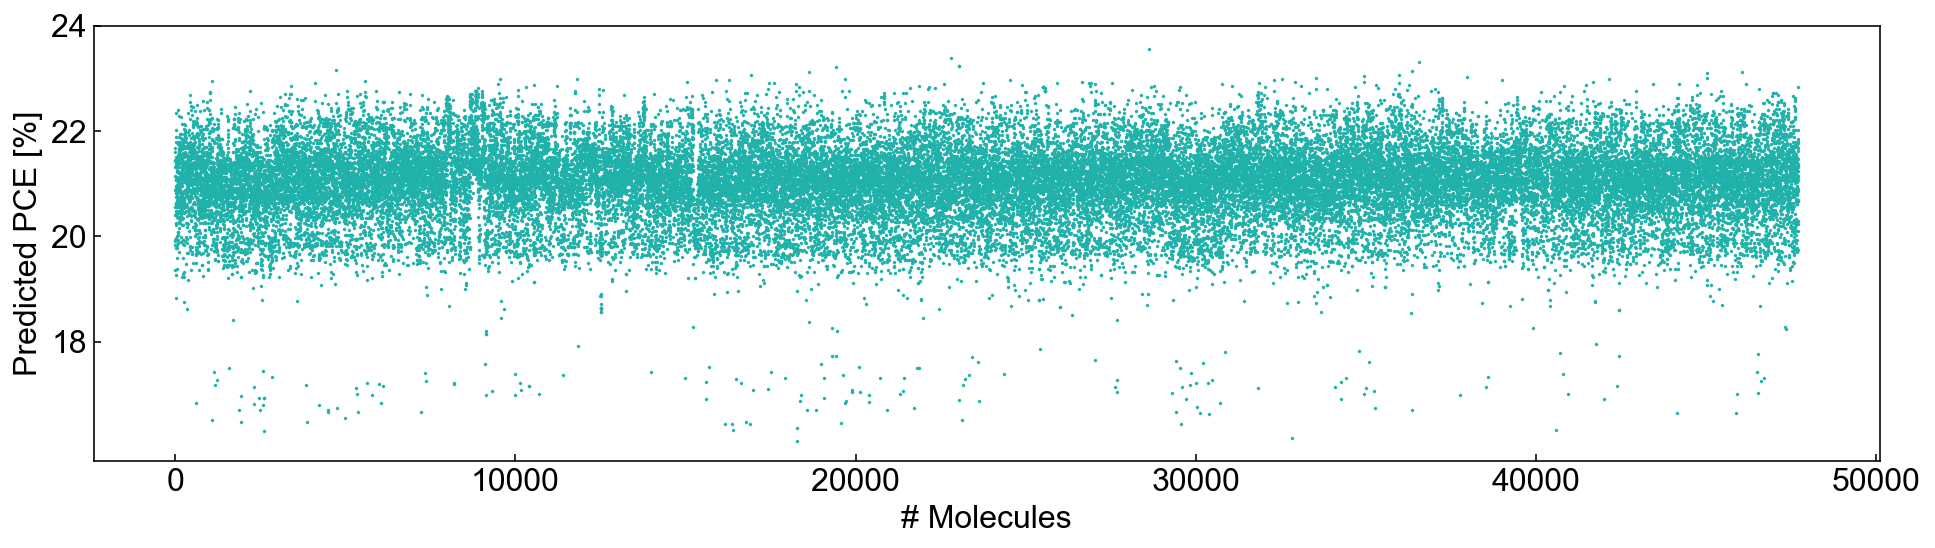

In [69]:
fontsize = 16
plt.figure(figsize=(16,4))
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.scatter(np.arange(len(y_pred)), y_pred, s=2.5,lw=0.1,c='lightseagreen')
plt.yticks(np.array([18, 20, 22, 24]))
plt.xlabel('# Molecules', fontsize=fontsize)
plt.ylabel('Predicted PCE [%]', fontsize=fontsize)
plt.tick_params(direction='in')
plt.rcParams['font.family']="Arial"

In [ ]:
filtered_df['PCE'] = y_pred  # Add the predicted PCE values to the DataFrame

# Filter the top 1% of molecules based on PCE values
top_1_percent_threshold = filtered_df['PCE'].quantile(0.99)  # Calculate the 99th percentile of PCE
top_1_percent_df = filtered_df[filtered_df['PCE'] >= top_1_percent_threshold]  # Select molecules with PCE >= 99th percentile

# Print the number of molecules in each filtered group
print(f"Number of molecules in the top 1%: {len(top_1_percent_df)}")

# Save the filtered DataFrame with top 1% molecules to a CSV file
top_1_percent_df.to_csv('top1%_molecules.csv', index=False)

In [4]:
df=pd.read_csv('./top1%data.csv',encoding='gb18030')
df

SMILES        DM  \
0                  CCOP(=S)(OCC)OC1=NC(=C(C=C1Cl)Cl)Cl  4.521589   
1    CC(C)(C)CC(C)(C)C1=CC(=C(C=C1)O)CC2=C(C=C(C=C2...  3.256968   
2               C1=CC(=CN=C1)CC(O)(P(=O)(O)O)P(=O)(O)O  4.999617   
3                          C1=C(C(=O)NC(=O)N1)C(F)(F)F  5.075576   
4    CC(C)(C1=CC(=C(C(=C1)Br)O)Br)C2=CC(=C(C(=C2)Br...  3.301395   
..                                                 ...       ...   
473            CC(C)OC(=O)C1(C2=CC=CC=C2C3=CC=CC=C31)O  0.811679   
474                 C1=CC(=C(C=C1F)F)C2=C(C=C(C=C2)F)F  1.378561   
475   C1=C(C=C(N=C1C(Cl)(Cl)Cl)C(Cl)(Cl)Cl)C(Cl)(Cl)Cl  2.212357   
476                        C1=C(C=NC(=C1Cl)C(F)(F)F)Cl  3.220321   
477  COC1=CC(=CC(=C1OC)OC)C(C2=CC(=C(C(=C2)OC)OC)OC...  3.635919   

     Mulliken_Charge  HOMO Energy (eV)  Energy Gap (eV)  HBA Count     cid  \
0          -0.350980         -0.218356         0.392531          5    2730   
1          -0.305899         -0.234860         0.457248          1    2799   
2          -0.589585         -0.237090         0.473942          4    5245   
3          -0.360895         -0.261704         0.456294          2    5899   
4          -0.296062         -0.245069         0.474120          2    6618   
..               ...               ...              ...        ...     ...   
473        -0.283324         -0.232191         0.438004          3  248047   
474        -0.127621         -0.243351         0.459674          0  249412   
475        -0.197022         -0.365393         0.498250          1  249733   
476        -0.212527         -0.330570         0.502056          1  249736   
477        -0.297562         -0.217490         0.465040          8  249987   

               skeleton_new  group        PCE  \
0                  c1ccncc1      1  22.684562   
1       c1ccc(Cc2ccccc2)cc1      5  22.547352   
2                  c1ccncc1      1  22.578405   
3      O=c1cc[nH]c(=O)[nH]1      4  22.548703   
4       c1ccc(Cc2ccccc2)cc1      5  22.718906   
..                      ...    ...        ...   
473  c1ccc2c(c1)Cc1ccccc1-2      2  22.614396   
474     c1ccc(-c2ccccc2)cc1      5  22.666169   
475                c1ccncc1      1  22.613319   
476                c1ccncc1      1  22.621341   
477     c1ccc(Cc2ccccc2)cc1      5  22.832649   

                                                   mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x0000019928A...   
1    <rdkit.Chem.rdchem.Mol object at 0x0000019928A...   
2    <rdkit.Chem.rdchem.Mol object at 0x0000019928A...   
3    <rdkit.Chem.rdchem.Mol object at 0x0000019928A...   
4    <rdkit.Chem.rdchem.Mol object at 0x0000019928A...   
..                                                 ...   
473  <rdkit.Chem.rdchem.Mol object at 0x0000019928B...   
474  <rdkit.Chem.rdchem.Mol object at 0x0000019928B...   
475  <rdkit.Chem.rdchem.Mol object at 0x0000019928B...   
476  <rdkit.Chem.rdchem.Mol object at 0x0000019928B...   
477  <rdkit.Chem.rdchem.Mol object at 0x0000019928B...   

                                                  MHFP  GB Prediction  \
0    [179995318  72011329  14316170 ... 176069654  ...           30.4   
1    [ 54297102  36123943   8411880 ... 115994684  ...           25.6   
2    [ 66652809  15928446 139428715 ...  19086922 1...           24.0   
3    [  9818374  40626309 124807823 ... 104254204 1...           20.6   
4    [ 54297102  36123943  55178419 ... 192888678 5...           16.6   
..                                                 ...            ...   
473  [113638662  43513882 241213284 ...  78748076 2...           18.8   
474  [143039995 254283215 149111725 ... 192888678 3...           10.7   
475  [111000236 312252844 178961281 ... 192888678 7...           23.0   
476  [297691353 128029832 145399841 ...  13566112 3...           13.2   
477  [ 56669554 312252844 205315314 ... 192888678  ...           18.9   

     NN Prediction  Average Prediction  
0             16.7                23.6  
1             22.0                23.8  
2       

In [5]:
# First filter: NN Prediction >= 20
condition1 = df['NN Prediction'] >= 20
filtered_df1 = df[condition1]  # Apply the condition and create the first filtered DataFrame

# Print the result of the first filter
print("Number of rows with NN Prediction >= 20:", len(filtered_df1))

# Second filter: Apply the second condition, total_dipole_moment >= 3.3 on the first filter result
condition2 = filtered_df1['DM'] >= 3.3
filtered_df2 = filtered_df1[condition2]  # Apply the condition and create the second filtered DataFrame

# Print the result of the second filter
print("Number of rows with NN Prediction >= 20 and total_dipole_moment >= 3.3:", len(filtered_df2))

# Third filter: Apply the third condition, HBA Count >= 3.3 on the second filter result
condition3 = filtered_df2['HBA Count'] >= 3.3
filtered_df3 = filtered_df2[condition3]  # Apply the condition and create the third filtered DataFrame

# Print the result of the third filter
print("Number of rows with NN Prediction >= 20, total_dipole_moment >= 3.3 and HBA Count >= 3.3:", len(filtered_df3))

Number of rows with NN Prediction>= 20: 143
Number of rows with NN Prediction>= 20 and total_dipole_moment >= 3.3: 71
Number of rows with NN Prediction>= 20, total_dipole_moment >= 3.3 and HBA_Count >= 3.3: 41


In [9]:
# Define a function to get the CAS number using the CID
def get_cas_number(cid):
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{cid}/JSON'  # PubChem API URL
    response = requests.get(url)  # Send the request
    if response.status_code == 200:  # If the request was successful
        data = response.json()  # Parse the JSON response
        for section in data.get('Record', {}).get('Section', []):  # Traverse sections of the record
            if section.get('TOCHeading') == 'Names and Identifiers':  # Check for section with identifiers
                for subsection in section.get('Section', []):  # Traverse sub-sections
                    if subsection.get('TOCHeading') == 'Other Identifiers':  # Check for other identifiers
                        for subsubsection in subsection.get('Section', []):  # Traverse sub-subsections
                            if subsubsection.get('TOCHeading') == 'CAS':  # Check for CAS information
                                for info in subsubsection.get('Information', []):
                                    return info.get('Value', {}).get('StringWithMarkup', [{}])[0].get('String', np.nan)
    return np.nan  # Return NaN if CAS number is not found

# Add CAS number to the DataFrame and show a progress bar
tqdm.pandas()  # Enable the tqdm progress bar
filtered_df3['cas_number'] = filtered_df3['cid'].progress_apply(get_cas_number)

# Drop rows where CAS number is missing
df_cas = filtered_df3.dropna(subset=['cas_number'])

# Print the number of rows with CAS numbers
print("Number of rows with CAS numbers:", len(df_cas))

# Display the resulting DataFrame
df_cas

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [02:05<00:00,  3.06s/it]

Number of rows with CAS numbers: 30


SMILES         DM  \
2               C1=CC(=CN=C1)CC(O)(P(=O)(O)O)P(=O)(O)O   4.999617   
66                   CC(C)C1=NC(=NC(=N1)NC)C(Cl)(Cl)Cl   4.583724   
69                       CCC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   4.124192   
74                     CCCCC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   4.155739   
75                   CCC(C)C1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   4.179687   
77                      CCCC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   4.140016   
103                 CC(C)CSC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   4.386380   
126                          CN(C)C(=S)SCN1C(=O)CCC1=O   4.942150   
129                       CCOP(=S)(OCC)OC1=CN=C(C=C1)F   7.148804   
164          CC1=NC=C(C(=C1O)CO)COC(=O)CCC(=O)OCCN(C)C   4.068122   
169  C1=C(C(=C(C(=C1O)O)O)CC2=C(C(=C(C=C2C(=O)O)O)O...   4.018793   
178  CC1=CC(=C(C=C1CC2=CC(=C(C=C2C)O)S(=O)(=O)O)S(=...   6.291504   
239         CCOC(=O)C(=CC1=CNC2=C1C=C(C=C2)Br)C(=O)OCC   5.601233   
240         CC(C(C(=O)ON1C(=O)CCC1=O)NC(=O)OC(C)(C)C)O   4.443089   
244        CC(=C)C(=O)NC1=CC2=NN(N=C2C=C1)C3=CC=CC=C3O   3.319343   
285  CC(CC(C1=CC=CC=C1)(C2=C(C=CC(=C2)OC)OC)O)N(C)C.Cl   3.302345   
288  CC(C)(C1=CC=C(C=C1)OCC(CS)O)C2=CC=C(C=C2)OCC(CS)O   4.971335   
294            C1=CC(=CN=C1)CCC(O)(P(=O)(O)O)P(=O)(O)O   4.016503   
299  CC(=O)SC(C)(C)CC(=O)N(C(CC(=O)O)S(=O)(=O)O)N1C...  10.079683   
323                                       C1CN=C(N1)SO   5.070181   
339               C1=C(C(=O)NC(=O)N1)C(F)(F)S(=O)(=O)O   5.376575   
350  CC1=CC(=C2C=CC3=C(C=C(N=C3C2=N1)C)C4=CC=C(C=C4...   3.315741   
358  CC1=C(C(=C(C(=C1OC)CC2=C(C(=C(C(=C2O)C(=O)C)O)...   3.806993   
419             CC1=CC(=C(C=C1O)C2=C(C=C(C(=C2)O)C)O)O   3.420383   
435                     C1=C(C(=O)NC(=O)N1)NS(=O)(=O)O   4.028627   
443                     C1=CC(=CN=C1)C(=O)NC(CO)(CO)CO   6.030545   
447                 CCOC(=O)CSC1=C(N=CN1C)[N+](=O)[O-]   6.907901   
454                 C1=C(C(=O)NC(=O)N1)C(=O)CN(CCO)CCO   5.262445   
459           CC(=O)NS(=O)(=O)C1=C(N=CN1C)[N+](=O)[O-]   9.560152   
462                 CC(C(C(C(C1=NC2=CC=CC=C2N1)O)O)O)O   7.915091   

     Mulliken_Charge  HOMO Energy (eV)  Energy Gap (eV)  HBA Count     cid  \
2          -0.589585         -0.237090         0.473942          4    5245   
66         -0.333445         -0.284195         0.453260          4   32654   
69         -0.393667         -0.297392         0.464824          4   34895   
74         -0.393811         -0.296530         0.464984          4   34906   
75         -0.393935         -0.297111         0.464616          4   34907   
77         -0.393776         -0.296740         0.464858          4   34911   
103        -0.393346         -0.278948         0.443126          5   35269   
126        -0.310371         -0.202932         0.433706          4   37977   
129        -0.357334         -0.226302         0.447878          5   38300   
164        -0.299408         -0.250547         0.485568          8   65782   
169        -0.310962         -0.221105         0.436146          8   68372   
178        -0.528791         -0.256527         0.465142          6   71229   
239        -0.310366         -0.218676         0.400784          4   98748   
240        -0.355163         -0.272819         0.530386          7   99018   
244        -0.354407         -0.212492         0.379579          5  100239   
285        -1.040540         -0.041861         0.293885          4  120835   
288        -0.302546         -0.226955         0.487780          6  121756   
294        -0.570406         -0.242077         0.475087          4  128523   
299        -0.520026         -0.265232         0.519884          8  131333   
323        -0.365604         -0.250453         0.539230          4  153385   
339        -0.502221         -0.260423         0.433352          4  157814   
350        -0.517309         -0.234090         0.381282          6  170300   
358        -0.308776         -0.227276         0.454358         10  181427   
419        -0.305372         -0.1976

In [10]:
input_csv = "molecule_data.csv"

# Read the CSV file
df = pd.read_csv(input_csv)

# Define the list of molecular scaffolds and their associated groups
# Assume each group contains a list of SMILES strings representing molecular scaffolds
skeleton_list = [
    ['c1nnn[nH]1', 'c1ccccc1', 'c1ccncc1', 'c1cscn1', 'c1ccsc1', 'C=c1ccc(=C)cc1', 'c1ccsc1', 'c1csc[nH+]1',
    'c1ncncn1', 'C1=NCCN1', 'c1c[nH]cn1', 'c1cc[nH+]cc1', 'S=c1cccc[nH]1'],
    ['c1ccc2c(c1)Cc1ccccc1-2', 'c1ccc2c(c1)c1ccccc1n2-c1ccncc1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
     'O=S(Cc1ccccn1)c1nc2ccccc2[nH]1', 'c1ccc2ccccc2c1', 'c1cnc2c(c1)ccc1cccnc12', 'O=c1ccc2cc3c4c(c2o1)CCCN4CCC3',
    'O=C1c2ccc3c4cccc5cccc(c6ccc(c2c36)C(=O)N1c1ccccc1)c54', 'c1ncc2ncn([C@H]3CCCO3)c2n1', 'O=C(NCCSCc1ccccc1)OCC1c2ccccc2-c2ccccc21',
    'O=c1ccc2ccccc2o1', 'c1ccc2c(c1)[nH]c1ccccc12'],
    ['', 'C1CCCCC1'],
    ['O=c1[nH]c(=O)c2[nH]cnc2[nH]1', 'O=C1C=CC(=O)N1', 'O=c1[nH]sc2ccccc12', 'O=c1cc[nH]c(=O)[nH]1', 
     'O=c1nc[nH]c2nc[nH]c12', 'O=c1nccc[nH]1', 'O=c1ccc2ccccc2[nH]1', 'O=C1/C(=C2/Nc3ccccc3C2=O)Nc2ccccc21',
     'O=C(Nc1ccccc1)Nc1ccccc1', 'O=C1C=CC(=O)N1c1ccccc1', 'C1=CC2(Cc3ccccc3N2)Oc2ccccc21', 
     'O=C1C=CC(=O)N1c1ccc(Cc2ccc(N3C(=O)C=CC3=O)cc2)cc1', 'O=C(c1ccccc1)c1ccccc1', 'O=C(/C=C/C=C/c1ccc2c(c1)OCO2)N1CCCCC1', 'O=c1cccc[nH]1'],
    ['c1ccc(-c2cccs2)cc1', 'c1ccc(-c2ccccn2)nc1', 'c1cnc2ncccc2c1', 'c1csc(-c2ccc(-c3cccs3)c3nsnc23)c1', 
     'c1ccc2scnc2c1', 'c1ccc(Cc2ccccc2)cc1', 'S=c1[nH]c2ccccc2[nH]1', 'c1ccc(-n2nc3ccccc3n2)cc1', 
     'c1ccc2[nH]ccc2c1', 'O=S1(=O)N=Cc2ccccc21', 'c1csc(-c2cccs2)c1', 'c1ccc(-c2ccccc2)cc1', 
     'c1ccc2[nH]cnc2c1', 'O=C1NC(=O)C(c2ccsc2)=C1c1ccsc1'],
    ['O=P(c1ccccc1)(c1ccccc1)c1ccccc1', 'c1ccc(P(c2ccccc2)c2ccccc2)cc1'],
    ['C1COCCN1', 'O=C1COCCN1', 'C1C[NH2+]CCN1', 'O=C1CC(=O)NC(=O)N1', 'O=C1CCC(=O)N1', 'C1CCOCC1', 'c1ccoc1'],
    ['C1C2CC3CC1CC(C2)C3', 'O=C1C2CC3CC(C2)CC1C3'],
    ['c1ccc(-c2nc(-c3ccccc3)nc(-c3ccccc3)n2)cc1']
]

# Flatten the skeleton list into a dictionary for quick lookup
skeleton_dict = {}
for group_index, skeletons in enumerate(skeleton_list, start=1):
    for skeleton in skeletons:
        skeleton_dict[skeleton] = group_index

# Create an empty DataFrame to store the filtered results
molecule_0618_scaffold = pd.DataFrame(columns=['smiles', 'skeleton', 'group'])

# Compute Murcko scaffold and filter molecules
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing molecules"):
    smiles = row['smiles']
    
    # Convert SMILES to molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        continue
    
    # Compute Murcko scaffold
    murcko_scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    murcko_scaffold_smiles = Chem.MolToSmiles(murcko_scaffold)
    
    # Check if the scaffold is in the predefined skeleton list
    if murcko_scaffold_smiles in skeleton_dict:
        group_index = skeleton_dict[murcko_scaffold_smiles]
        # Add to the result DataFrame
        molecule_0618_scaffold = molecule_0618_scaffold.append({
            'smiles': smiles,
            'skeleton': murcko_scaffold_smiles,
            'group': group_index
        }, ignore_index=True)

# Concatenate the filtered data with the original dataframe
molecule_data_scaffold = pd.concat([molecule_data_scaffold, df], axis=1)

# Remove duplicate columns
molecule_data_scaffold = molecule_data_scaffold.loc[:, ~molecule_data_scaffold.columns.duplicated()]

# Add molecule column with fingerprints using RDKit
PandasTools.AddMoleculeColumnToFrame(molecule_0618_scaffold, 'smiles', 'mol', includeFingerprints=True)

# Save the filtered results to a new CSV file
output_csv = "molecule_data_scaffold.csv"
molecule_data_scaffold.to_csv(output_csv, index=False)

Processing molecules: 100%|█████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 209.13it/s]


smiles  \
0                                            Cn1nnnc1S   
1                                          I.Nc1ccccc1   
2                                        NCC=Cc1ccccc1   
3         CSCC[C@H](NC(=O)OCC1c2ccccc2c3ccccc13)C(O)=O   
4                                             c1ccncc1   
5                                            Cc1ccncc1   
6                                     CC(C)(C)c1ccncc1   
7                     OC(=O)c1c(F)c(F)c(F)c(F)c1C(O)=O   
8                                  [I-].NCCc1ccc(O)cc1   
9                                BrCc1cc(CBr)cc(CBr)c1   
10                     c1ccc2c(c1)n(c3ccncc3)c4ccccc24   
11   CN(C)CCCNC(=O)c1cc(c2ccccc2)c3ccc4c(cc(nc4c3n1...   
12                                   OC(=O)c1csc(Cl)n1   
13                                            N#CCCC#N   
14                                      OC(=O)c1ccccc1   
15                              OC(=O)c1ccc(cc1)C(O)=O   
16                      OC(=O)c1cc(cc(c1)C(O)=O)C(O)=O   
17                                          NC(N)=NC#N   
18       Cc1c(C[S](=O)c2[nH]c3ccccc3n2)nccc1OCC(F)(F)F   
19   FC(F)(F)[S](=O)(=O)N(c1ccccn1)[S](=O)(=O)C(F)(F)F   
20             FC(F)(F)[S](=O)(=O)N[S](=O)(=O)C(F)(F)F   
21                                           Nc1ccccn1   
22                       OC(=O)c1cc(ccc1O)[S](O)(=O)=O   
23       [OH-].CCCCCCCCCCCCCC[N+](C)(C)CCC[S](O)(=O)=O   
24              [H-].[K+].OC(=O)c1ccc(cc1)[S](O)(=O)=O   
25                          CN1C(=O)N(C)c2nc[nH]c2C1=O   
26                           Cn1cnc2N(C)C(=O)NC(=O)c12   
27                   O=[P](c1ccccc1)(c2ccccc2)c3ccccc3   
28         CC(C)O[P](=O)(C[P](=O)(OC(C)C)OC(C)C)OC(C)C   
29   Fc1c(F)c(F)c(P(c2c(F)c(F)c(F)c(F)c2F)c3c(F)c(F...   
30                                       CC(N)C1CCCCC1   
31                                    Brc1ccc2ccccc2c1   
32                    [Na+].Cc1ccc(cc1)[S]([O-])(=O)=O   
33               [Na].CCCCCCCCCCCCO[S](=O)(=O)c1ccccc1   
34                               Nc1cc2cccnc2c3ncccc13   
35                     OC(=O)C(=Cc1sc(cc1)c2ccccc2)C#N   
36              CCCCOc1ccc(cc1)c2sc(cc2)C=C(C#N)C(O)=O   
37        CCCCN(CCCC)c1ccc(cc1)c2sc(cc2)C=C(C#N)C(O)=O   
38                        Cn1cnc2N(C)C(=O)N(C)C(=O)c12   
39                                    N#Cc1ccc(cc1)C#N   
40                                      Nc1ccc(cc1)C#N   
41                          C[N+](C)(C)CC(O)CC([O-])=O   
42                  COc1cc(CNC(=O)CCCC\C=C\C(C)C)ccc1O   
43                      OC(=O)CCCCCCCCCCN1C(=O)C=CC1=O   
44                                 I.CN(C)C(=N)NC(N)=N   
45                OC(=O)C1=Cc2cc3CCCN4CCCc(c2OC1=O)c34   
46                                             NC(N)=S   
47   CC(C)c1cccc(C(C)C)c1N2C(=O)c3ccc4c5cccc6c(ccc(...   
48   CC(C)=CCC\C(C)=C\C=C\C(C)=C\C=C\C(C)=C\C=C\C=C...   
49                                     O=C1NSc2ccccc12   
50                                    FC1=CNC(=O)NC1=O   
51                                  [Br-].NC([NH3+])=N   
52                                           NC(=O)C=C   
53          FC1=C(F)C(C(=C(F)C1=C(C#N)C#N)F)=C(C#N)C#N   
54                                             NCC(F)F   
55                                          NCC(F)(F)F   
56                                      NC(=N)C(F)(F)F   
57            [Br-].CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC   
58                                    [Br-].CCCC[NH3+]   
59                           [Br-].C[N+](C)(C)c1ccccc1   
60                                   [I-].NC([NH3+])=N   
61                                       [Cl-].C[NH3+]   
62                               [I-].[NH3+]CCc1ccccc1   
63                            [I-].[NH3+]CCc1ccc(F)cc1   
64                                    NCc1cccc2ccccc12   
65                  [H+].[Cl-].NC(N)=NC(N)=NCCc1ccccc1   
66   Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO[P](O)(=O)O[P]...   
67         COc1ccc(CSC[C@H](NC(=O)OC(C)(C)C)C(O)=O)cc1   
68            CC(C)(C)OC(=O)N[C@@H](CSCc1ccccc
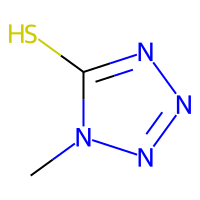
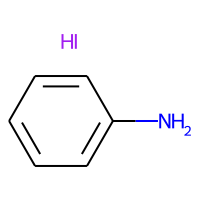
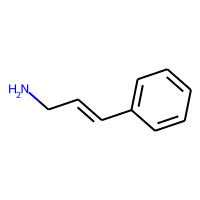
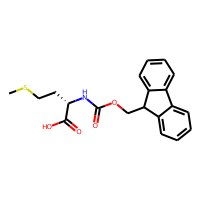
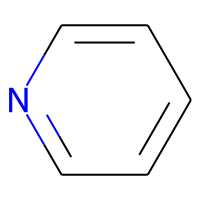
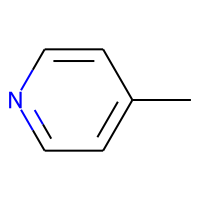
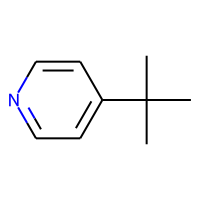
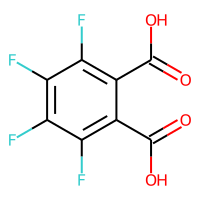
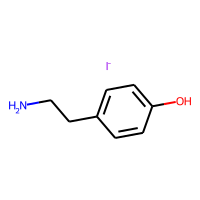
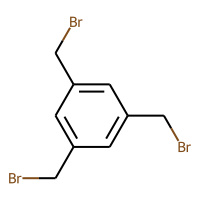
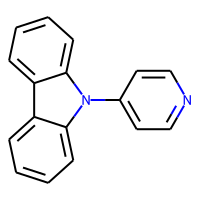
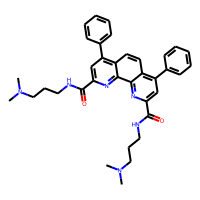
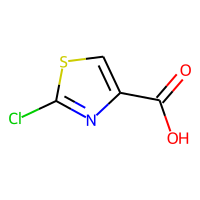
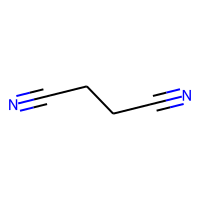
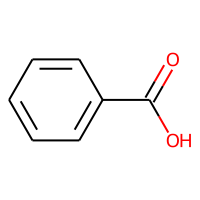
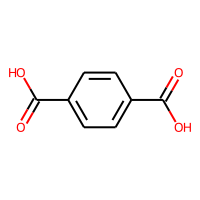
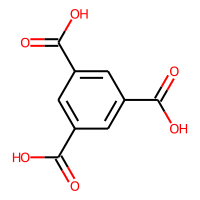
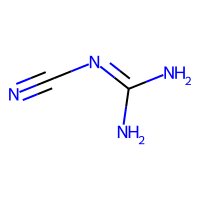
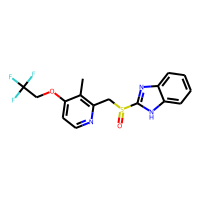
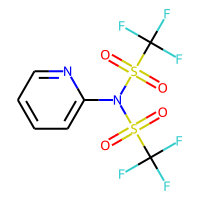
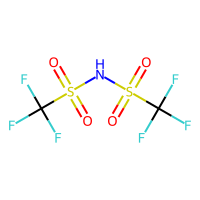
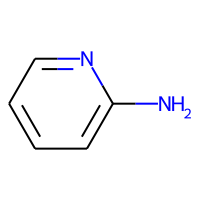
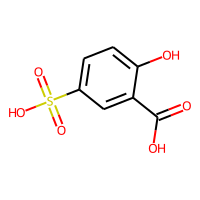
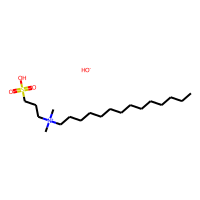
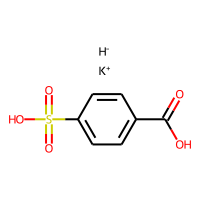
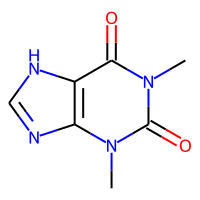
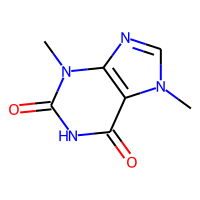
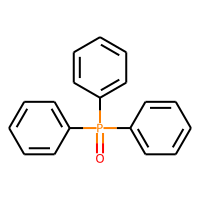
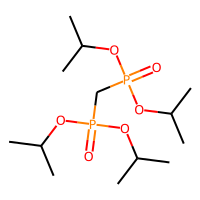
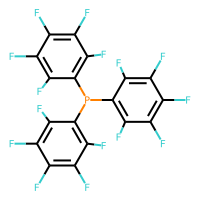
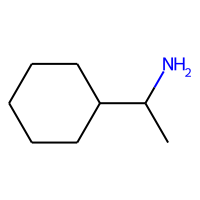
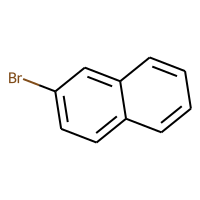
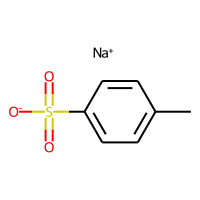
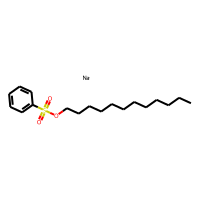
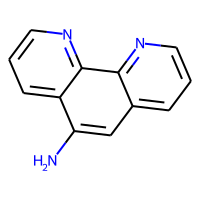
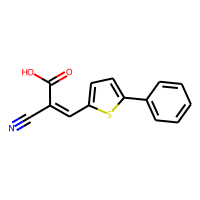
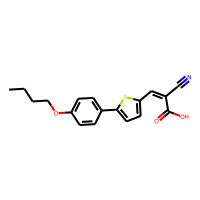
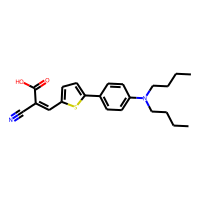
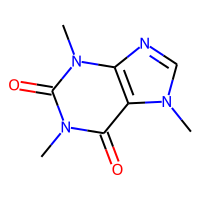
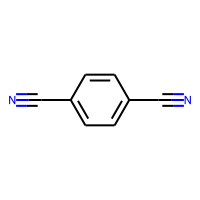
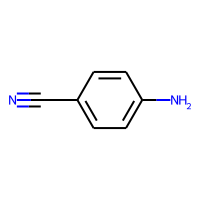
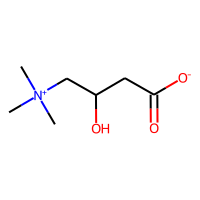
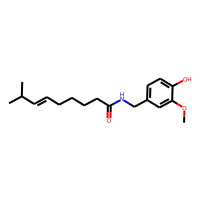
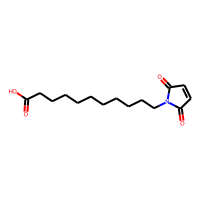
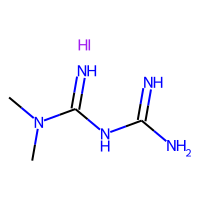
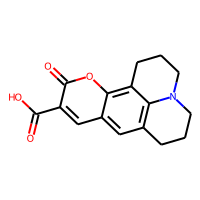
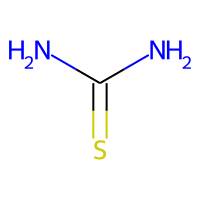
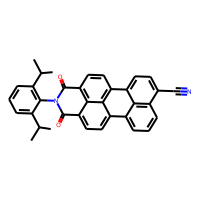
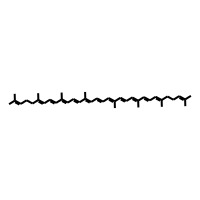
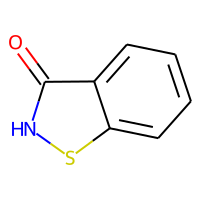
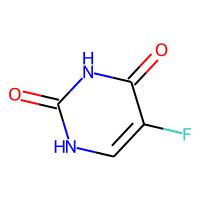
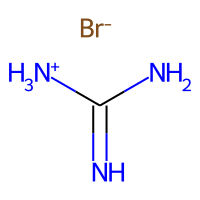
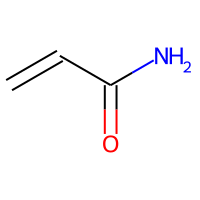
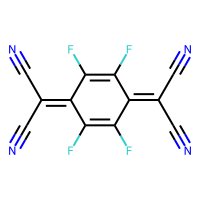
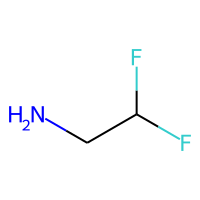
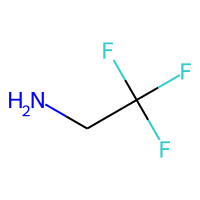
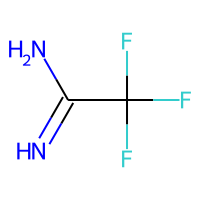
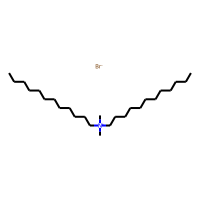
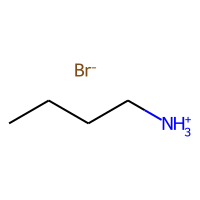
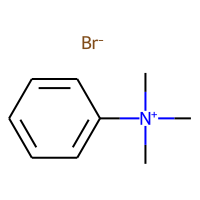
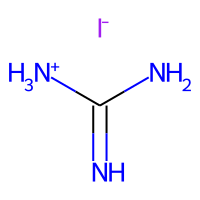
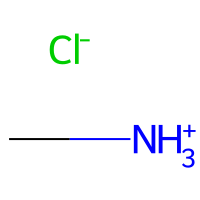
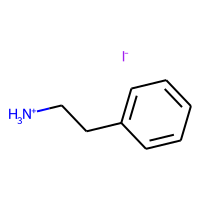
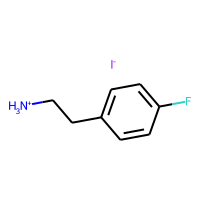
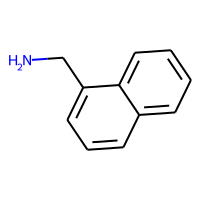
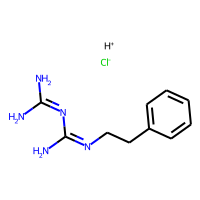
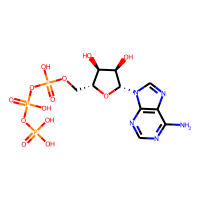
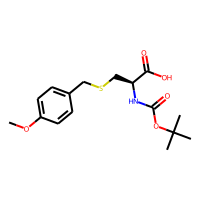
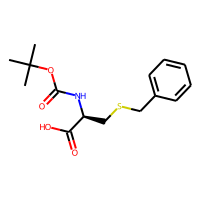
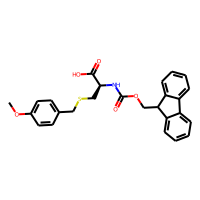
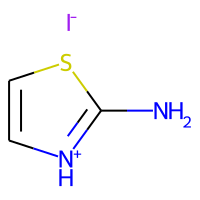
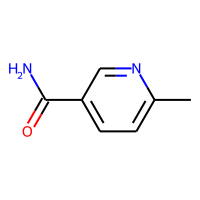
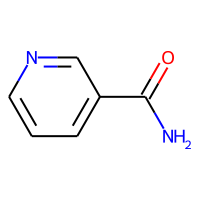
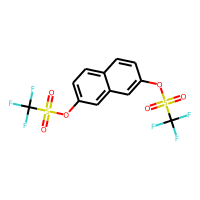
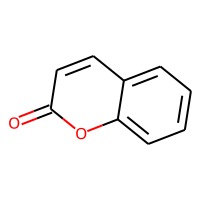
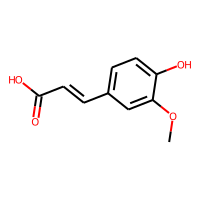
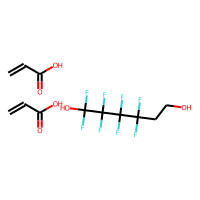
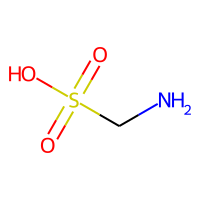
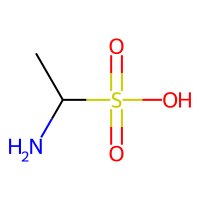
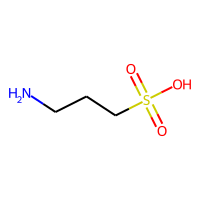
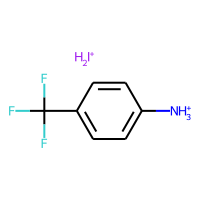
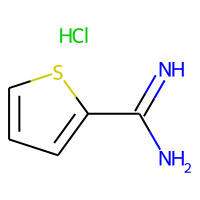
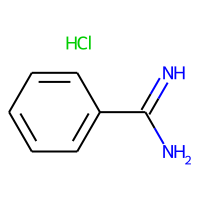
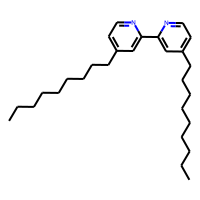
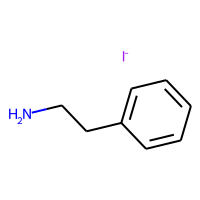
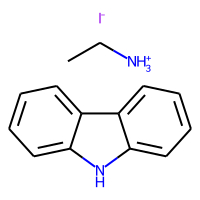
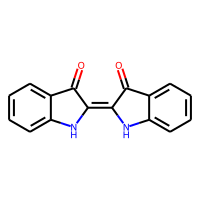
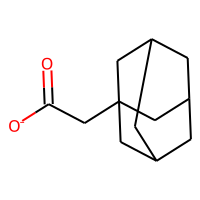
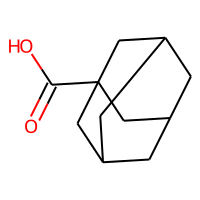
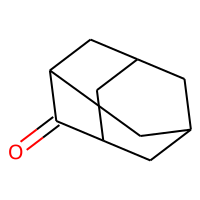
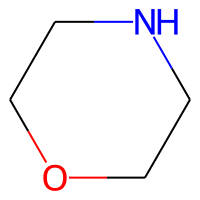
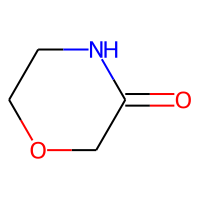
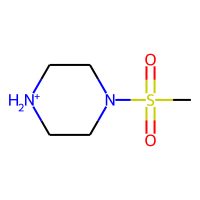
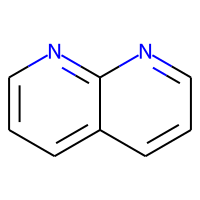
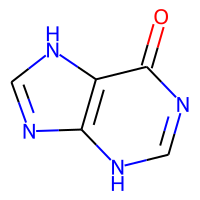
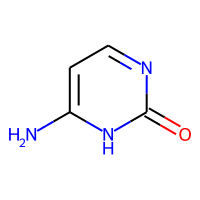
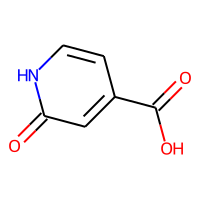
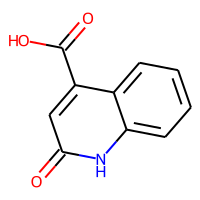
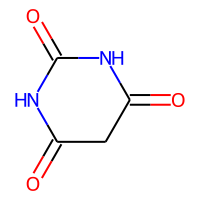
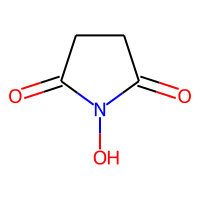
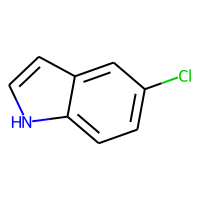
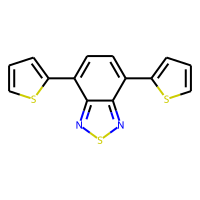
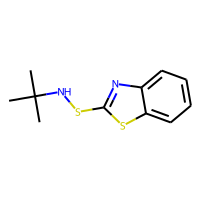
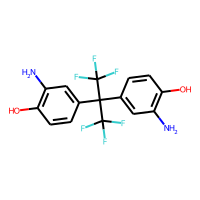
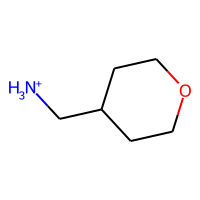
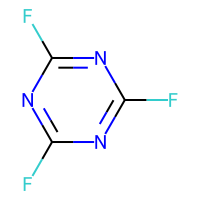
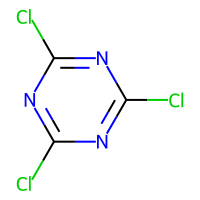
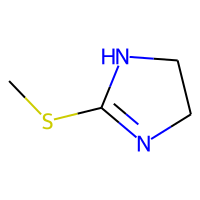
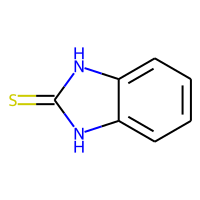
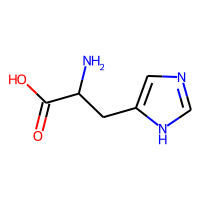
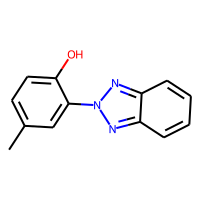
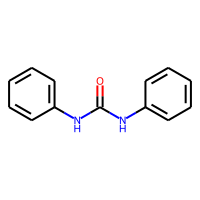
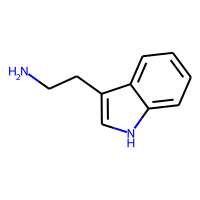
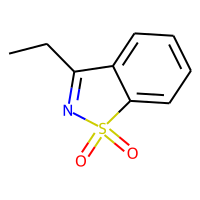
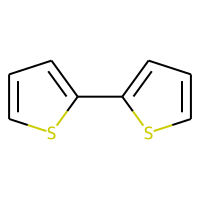
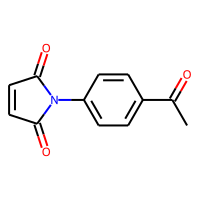
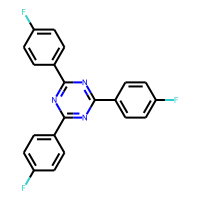
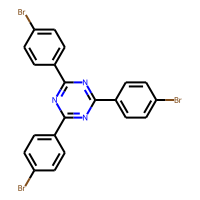
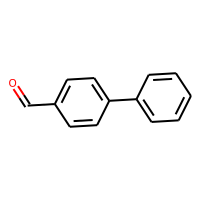
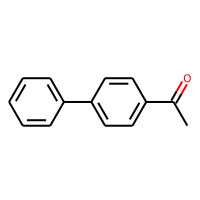
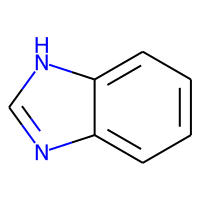
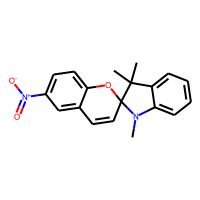
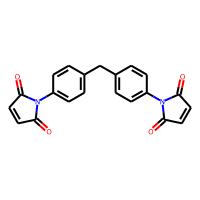
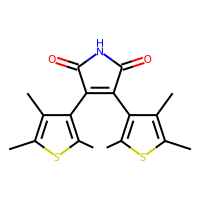
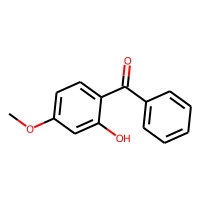
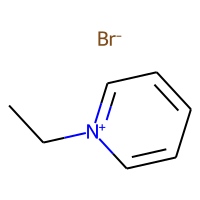
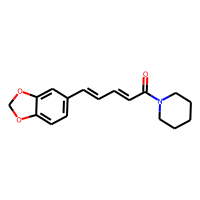
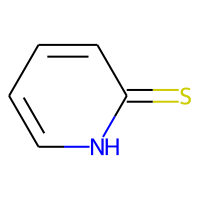
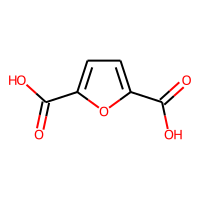

In [11]:
molecule_data_scaffold

Row 2: Skeleton matches count: 2
Row 2: Group matches count: 4
Row 66: Skeleton matches count: 1
Row 66: Group matches count: 2
Row 69: Skeleton matches count: 0
Row 69: Group matches count: 1
Row 74: Skeleton matches count: 1
Row 74: Group matches count: 3
Row 75: Skeleton matches count: 0
Row 75: Group matches count: 3
Row 77: Skeleton matches count: 1
Row 77: Group matches count: 2
Row 103: Skeleton matches count: 0
Row 103: Group matches count: 1
Row 126: Skeleton matches count: 1
Row 126: Group matches count: 4
Row 129: Skeleton matches count: 2
Row 129: Group matches count: 1
Row 164: Skeleton matches count: 2
Row 164: Group matches count: 7
Row 169: Skeleton matches count: 0
Row 169: Group matches count: 5
Row 178: Skeleton matches count: 0
Row 178: Group matches count: 6
Row 239: Skeleton matches count: 1
Row 239: Group matches count: 3
Row 240: Skeleton matches count: 1
Row 240: Group matches count: 4
Row 244: Skeleton matches count: 1
Row 244: Group matches count: 3
Row 285: 

SMILES     cid  \
2               C1=CC(=CN=C1)CC(O)(P(=O)(O)O)P(=O)(O)O    5245   
66                   CC(C)C1=NC(=NC(=N1)NC)C(Cl)(Cl)Cl   32654   
69                       CCC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   34895   
74                     CCCCC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   34906   
75                   CCC(C)C1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   34907   
77                      CCCC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   34911   
103                 CC(C)CSC1=NC(=NC(=N1)N)C(Cl)(Cl)Cl   35269   
126                          CN(C)C(=S)SCN1C(=O)CCC1=O   37977   
129                       CCOP(=S)(OCC)OC1=CN=C(C=C1)F   38300   
164          CC1=NC=C(C(=C1O)CO)COC(=O)CCC(=O)OCCN(C)C   65782   
169  C1=C(C(=C(C(=C1O)O)O)CC2=C(C(=C(C=C2C(=O)O)O)O...   68372   
178  CC1=CC(=C(C=C1CC2=CC(=C(C=C2C)O)S(=O)(=O)O)S(=...   71229   
239         CCOC(=O)C(=CC1=CNC2=C1C=C(C=C2)Br)C(=O)OCC   98748   
240         CC(C(C(=O)ON1C(=O)CCC1=O)NC(=O)OC(C)(C)C)O   99018   
244        CC(=C)C(=O)NC1=CC2=NN(N=C2C=C1)C3=CC=CC=C3O  100239   
285  CC(CC(C1=CC=CC=C1)(C2=C(C=CC(=C2)OC)OC)O)N(C)C.Cl  120835   
288  CC(C)(C1=CC=C(C=C1)OCC(CS)O)C2=CC=C(C=C2)OCC(CS)O  121756   
294            C1=CC(=CN=C1)CCC(O)(P(=O)(O)O)P(=O)(O)O  128523   
299  CC(=O)SC(C)(C)CC(=O)N(C(CC(=O)O)S(=O)(=O)O)N1C...  131333   
323                                       C1CN=C(N1)SO  153385   
339               C1=C(C(=O)NC(=O)N1)C(F)(F)S(=O)(=O)O  157814   
350  CC1=CC(=C2C=CC3=C(C=C(N=C3C2=N1)C)C4=CC=C(C=C4...  170300   
358  CC1=C(C(=C(C(=C1OC)CC2=C(C(=C(C(=C2O)C(=O)C)O)...  181427   
419             CC1=CC(=C(C=C1O)C2=C(C=C(C(=C2)O)C)O)O  220284   
435                     C1=C(C(=O)NC(=O)N1)NS(=O)(=O)O  227929   
443                     C1=CC(=CN=C1)C(=O)NC(CO)(CO)CO  234412   
447                 CCOC(=O)CSC1=C(N=CN1C)[N+](=O)[O-]  236062   
454                 C1=C(C(=O)NC(=O)N1)C(=O)CN(CCO)CCO  238868   
459           CC(=O)NS(=O)(=O)C1=C(N=CN1C)[N+](=O)[O-]  240366   
462                 CC(C(C(C(C1=NC2=CC=CC=C2N1)O)O)O)O  244832   

                                   skeleton_new        PCE   cas_number  \
2                                      c1ccncc1  22.578405  105462-24-6   
66                                     c1ncncn1  22.520295   24803-26-7   
69                                     c1ncncn1  22.671815   30339-40-3   
74                                     c1ncncn1  22.563150   30339-70-9   
75                                     c1ncncn1  22.645959   30339-73-2   
77                                     c1ncncn1  22.563150   30339-80-1   
103                                    c1ncncn1  22.645959   30369-53-0   
126                               O=C1CCC(=O)N1  22.995862   38221-37-3   
129                                    c1ccncc1  22.556199   39624-86-7   
164                                    c1ccncc1  22.629671   33605-94-6   
169                         c1ccc(Cc2ccccc2)cc1  22.608897     552-21-6   
178                         c1ccc(Cc2ccccc2)cc1  22.681150   78480-14-5   
239                            c1ccc2[nH]ccc2c1  22.739023   93941-03-8   
240                               O=C1CCC(=O)N1  22.912706   63076-44-8   
244                    c1ccc(-n2nc3ccccc3n2)cc1  22.532263   36325-69-6   
285                         c1ccc(Cc2ccccc2)cc1  22.501610     903-17-3   
288                         c1ccc(Cc2ccccc2)cc1  22.536794   29953-09-1   
294                                    c1ccncc1  22.557182  104261-69-0   
299                               O=C1CCC(=O)N1  22.829964  131068-49-0   
323                                    C1=NCCN1  22.555186   72255-29-9   
339                        O=c1cc[nH]c(=O)[nH]1  22.965604  158698-42-1   
350  c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1  22.807133  166301-18-4   
358                         c1ccc(Cc2ccccc2)cc1  23.053904  131836-01-6   
419                         c1ccc(-c2ccccc2)cc1  22.746946    4371-34-0   
435                        O=c1cc[nH]c(=O)[nH]1  22.514722    5435-16-5   
443                                    c1ccncc1  22
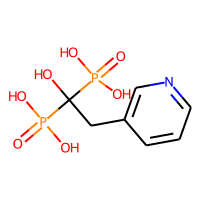
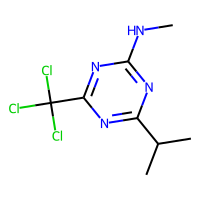
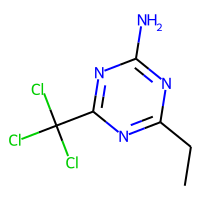
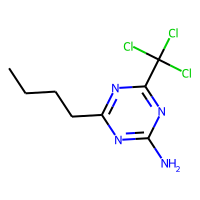
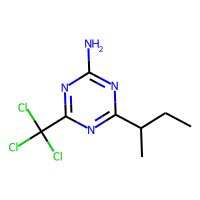
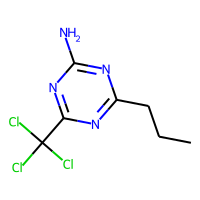
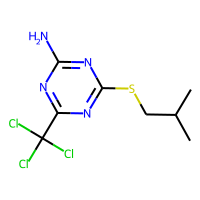
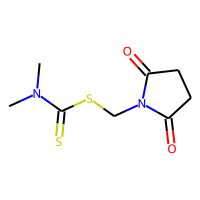
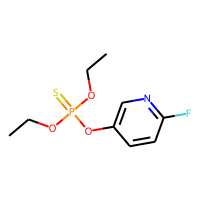
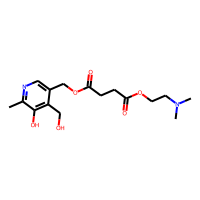
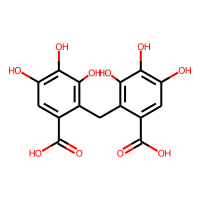
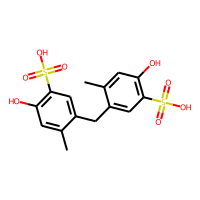
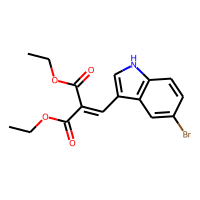
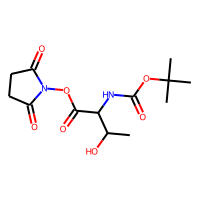
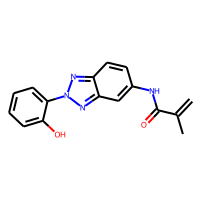
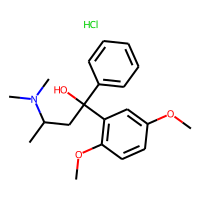
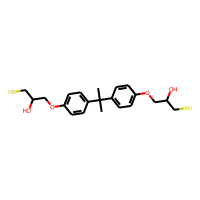
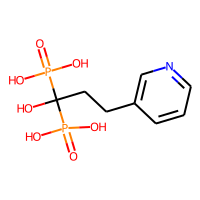
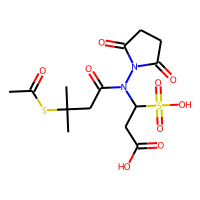
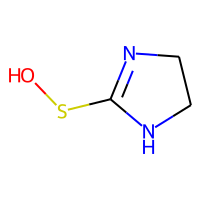
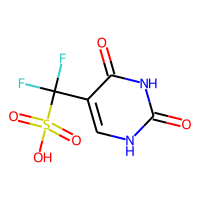
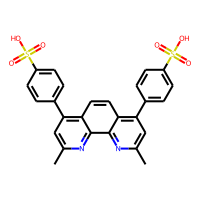
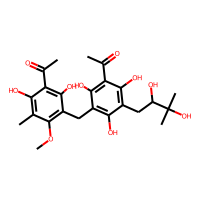
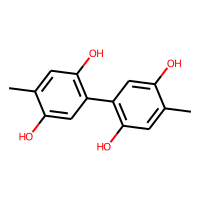
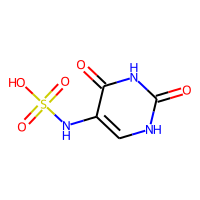
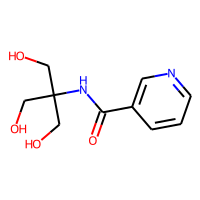
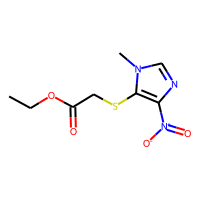
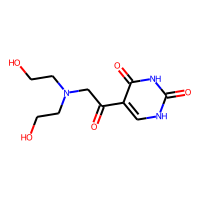
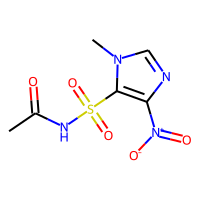
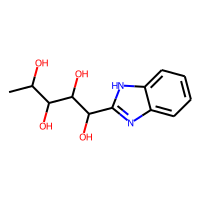

In [163]:
# New molecule DataFrame
new_molecules = df_cas  

# Existing molecule DataFrame
existing_molecules = molecule_data_scaffold  

# Define a function to calculate scaffold similarity between two molecules
def calculate_mcs_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        mcs_result = rdFMCS.FindMCS([mol1, mol2])
        mcs_smarts = mcs_result.smartsString
        mcs_mol = Chem.MolFromSmarts(mcs_smarts)
        if mcs_mol is not None:
            return mcs_result.numAtoms / min(mol1.GetNumAtoms(), mol2.GetNumAtoms())
    return 0.0

# Define a function to find all rows with the same scaffold as the new molecule,
# where the target_PCE value is within 1.5 of the new molecule’s PCE value,
# and the scaffold similarity is greater than 0.5.
def find_skeleton_matches(new_row, existing_df):
    same_skeleton = existing_df[existing_df['skeleton'] == new_row['skeleton_new']]
    skeleton_matches = same_skeleton[(abs(same_skeleton['target_PCE'] - new_row['PCE']) <= 1.5)]
    return skeleton_matches

# Define a function to find all rows with the same group as the new molecule,
# where the target_PCE value is within 1.5 of the new molecule’s PCE value,
# and the scaffold similarity is greater than 0.7.
def find_group_matches(new_row, existing_df):
    same_group = existing_df[existing_df['group'] == new_row['group']]
    group_matches = same_group[(abs(same_group['target_PCE'] - new_row['PCE']) <= 1.5) & 
                               (same_group['smiles'].apply(lambda x: calculate_mcs_similarity(x, new_row['SMILES'])) > 0.7)]
    return group_matches

# Create a new DataFrame to store the results
result_df = new_molecules.copy()

# Ensure all required columns exist in the result_df
columns_to_add = ['smiles', 'skeleton', 'Doi', 'existing_row_index', 'target_PCE']
for col in columns_to_add:
    if col not in result_df.columns:
        result_df[col] = None

# Iterate over all new molecules and accumulate information
for index, new_row in new_molecules.iterrows():
    try:
        skeleton_matches = find_skeleton_matches(new_row, existing_molecules)
        group_matches = find_group_matches(new_row, existing_molecules)
        
        # Print counts
        print(f"Row {index}: Skeleton matches count: {len(skeleton_matches)}")
        print(f"Row {index}: Group matches count: {len(group_matches)}")

        # Combine results
        combined_matches = pd.concat([skeleton_matches, group_matches]).drop_duplicates()

        # Accumulate information
        for col in existing_molecules.columns:
            if col not in new_molecules.columns:
                result_df.at[index, col] = ','.join(combined_matches[col].astype(str).unique())
        result_df.at[index, 'existing_row_index'] = ','.join(combined_matches.index.astype(str).unique())  # Save row indexes

    except Exception as e:
        print(f"Error processing row {index}: {e}")

# Define the columns you need
selected_columns = ['SMILES', 'cid', 'skeleton_new', 'PCE', 'cas_number', 'smiles', 'skeleton', 'group', 'target_PCE', 'Doi', 'existing_row_index']

# Select these columns
df_selected = result_df[selected_columns]

# Add molecule column
PandasTools.AddMoleculeColumnToFrame(df_selected, 'SMILES', 'mol', includeFingerprints=True)

df_selected